In [1]:
file_path = r"C:\Users\james\Documents\Github\Traffic_Volume_Prediction"

In [2]:
import pandas as pd

train = pd.read_csv(file_path + r"\Data\train.csv")
test = pd.read_csv(file_path + r"\Data\test.csv")

## X, y 분리

In [3]:
# 타겟 컬럼과 시간 시차 설정
TARGET = '1005004000_velocity'
HORIZON = 24  # 24시간 시차

# 24시간 시차 적용하여 데이터 생성
train['y_shifted'] = train[TARGET].shift(-HORIZON)  # 24시간 이후 값을 타겟으로 설정
test['y_shifted'] = test[TARGET].shift(-HORIZON)

# 비어 있는 데이터 제거
train = train.dropna(subset=['y_shifted'])
test = test.dropna(subset=['y_shifted'])

# X_train, y_train 설정
X_train = train.drop(columns=[TARGET, 'y_shifted'])
y_train = train[['y_shifted']]

# X_test, y_test 설정
X_test = test.drop(columns=[TARGET, 'y_shifted'])
y_test = test[['y_shifted']]

# 결과 출력 (확인용)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (19261, 68)
y_train shape: (19261, 1)
X_test shape: (696, 68)
y_test shape: (696, 1)


## Sliding Window 방식의 모델링

### 모델링(lgbm)

In [4]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# 설정 값
N_TEST = 12
N_SPLIT = 27

lgb_params = {
    'learning_rate': 0.04920408281422388,
    'num_leaves': 84,
    'max_depth': 9,
    'min_child_samples': 62,
    'subsample': 0.8114337992568297,
    'colsample_bytree': 0.9241942074377165,
    'reg_alpha': 0.13177582213039427,
    'reg_lambda': 0.8708071123519207,
    'n_jobs': -1
}

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# MAPE 점수 리스트
mape_scores = []
trials = 1

# TimeSeriesSplit을 이용한 검증
for train_idx, val_idx in tscv.split(X_train):
    if trials <= N_SPLIT - N_TEST:
        trials += 1
        continue
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # LightGBM 모델 학습
    lgb_model = lgb.LGBMRegressor(objective='mape', verbose=-1, **lgb_params)
    lgb_model.fit(X_tr, y_tr.values.ravel()) 
    
    # 예측 및 MAPE 계산
    y_pred = lgb_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    mape_scores.append(mape)
    print(f"validation MAPE: {mape}")

# 테스트 세트에 대한 최종 예측
lgb_model = lgb.LGBMRegressor(objective='mape', verbose=-1, **lgb_params)
lgb_model.fit(X_train, y_train.values.ravel()) 
y_test_pred = lgb_model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# 결과 출력
print("")
print("Results: ")
print("Average Validation MAPE:", np.mean(mape_scores))
print("Validation MAPE Std Dev:", np.std(mape_scores))
print("Final Test MAPE:", test_mape)

validation MAPE: 0.08824528301564205
validation MAPE: 0.09438063761554077
validation MAPE: 0.134373925859019
validation MAPE: 0.161258384366563
validation MAPE: 0.09187413465203516
validation MAPE: 0.08093651769554508
validation MAPE: 0.06577421000655505
validation MAPE: 0.07237334381916184
validation MAPE: 0.07490756034440998
validation MAPE: 0.08015314524713865
validation MAPE: 0.10472345419114071
validation MAPE: 0.08563741845916209

Results: 
Average Validation MAPE: 0.09455316793932615
Validation MAPE Std Dev: 0.02640091081491587
Final Test MAPE: 0.07875222668847578


### 파라미터 최적화(lgbm)

In [5]:
# import lightgbm as lgb
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import optuna
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# # 최적화 목표 함수 정의
# def objective(trial):
#     # 하이퍼파라미터 탐색 범위 정의
#     param = {
#         'objective': 'mape',
#         'metric': 'mape',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 200),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
#     }

    
#     mape_scores = []
#     trials = 1

#     # TimeSeriesSplit을 사용한 교차 검증
#     for train_idx, val_idx in tscv.split(X_train):
#         if trials <= N_SPLIT - N_TEST:
#             trials += 1
#             continue

#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # 모델 학습
#         model = lgb.LGBMRegressor(**param)
#         model.fit(X_tr, y_tr.values.ravel())

#         # 예측 및 MAPE 계산
#         y_pred = model.predict(X_val)
#         mape = mean_absolute_percentage_error(y_val, y_pred)
#         mape_scores.append(mape)

#     # 평균 MAPE 반환 (Optuna가 최소화할 값)
#     return np.mean(mape_scores)

# # Optuna 스터디 생성 및 최적화 실행
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # 최적 하이퍼파라미터 및 결과 출력
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # 최적 파라미터로 최종 모델 학습 및 테스트 예측
# best_params = trial.params
# model = lgb.LGBMRegressor(**best_params)
# model.fit(X_train, y_train.values.ravel())
# y_test_pred = model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 최종 결과 출력
# print("\nFinal Test MAPE:", test_mape)

### 모델링(xgboost)

In [6]:
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# xgb_params = {
#     'n_jobs': -1,
#     'learning_rate': 0.05794263457885568,
#     'max_depth': 6,
#     'min_child_weight': 4,
#     'subsample': 0.7344045283452703,
#     'colsample_bytree': 0.9038004924012054,
#     'reg_alpha': 0.021676042228145752,
#     'reg_lambda': 0.0010158057245436504,
# }

# # MAPE 점수 리스트
# mape_scores = []
# trials = 1

# # TimeSeriesSplit을 이용한 검증
# for train_idx, val_idx in tscv.split(X_train):
#     if trials <= N_SPLIT - N_TEST:
#         trials += 1
#         continue

#     X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     # XGBoost 모델 학습
#     xgb_model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0, **xgb_params)
#     xgb_model.fit(X_tr, y_tr.values.ravel())
    
#     # 예측 및 MAPE 계산
#     y_pred = xgb_model.predict(X_val)
#     mape = mean_absolute_percentage_error(y_val, y_pred)
#     mape_scores.append(mape)
#     print(f"validation MAPE: {mape}")

# # 테스트 세트에 대한 최종 예측
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0, **xgb_params)
# xgb_model.fit(X_train, y_train.values.ravel())
# y_test_pred = xgb_model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 결과 출력
# print("\nResults:")
# print("Average Validation MAPE:", np.mean(mape_scores))
# print("Validation MAPE Std Dev:", np.std(mape_scores))
# print("Final Test MAPE:", test_mape)

### 파라미터 최적화(xgboost)

In [7]:
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import optuna
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# # 최적화 목표 함수 정의
# def objective(trial):
#     # 하이퍼파라미터 탐색 범위 정의
#     param = {
#         'objective': 'reg:squarederror',  # 기본 손실 함수 사용
#         'verbosity': 0,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#         'n_jobs': -1  
#     }

    
#     mape_scores = []
#     trials = 1

#     # TimeSeriesSplit을 사용한 교차 검증
#     for train_idx, val_idx in tscv.split(X_train):
#         if trials <= N_SPLIT - N_TEST:
#             trials += 1
#             continue

#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # 모델 학습
#         model = xgb.XGBRegressor(**param)
#         model.fit(X_tr, y_tr.values.ravel())

#         # 예측 및 MAPE 계산
#         y_pred = model.predict(X_val)
#         mape = mean_absolute_percentage_error(y_val, y_pred)
#         mape_scores.append(mape)

#     # 평균 MAPE 반환 (Optuna가 최소화할 값)
#     return np.mean(mape_scores)

# # Optuna 스터디 생성 및 최적화 실행
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # 최적 하이퍼파라미터 및 결과 출력
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # 최적 파라미터로 최종 모델 학습 및 테스트 예측
# best_params = trial.params
# model = xgb.XGBRegressor(**best_params)
# model.fit(X_train, y_train.values.ravel())
# y_test_pred = model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 최종 결과 출력
# print("\nFinal Test MAPE:", test_mape)

### 모델링(random forest)

In [8]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# rf_params ={
#     'n_estimators': 202,
#     'max_depth': 22,
#     'min_samples_split': 12,
#     'min_samples_leaf': 4,
#     'max_features': 0.5197759173571685,
#     'n_jobs': -1,  # 모든 CPU 코어 사용
#     'random_state': 42
# }

# # MAPE 점수 리스트
# mape_scores = []
# trials = 1

# # TimeSeriesSplit을 이용한 검증
# for train_idx, val_idx in tscv.split(X_train):
#     if trials <= N_SPLIT - N_TEST:
#         trials += 1
#         continue

#     X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     # RandomForest 모델 학습
#     rf_model = RandomForestRegressor( **rf_params)
#     rf_model.fit(X_tr, y_tr.values.ravel())
    
#     # 예측 및 MAPE 계산
#     y_pred = rf_model.predict(X_val)
#     mape = mean_absolute_percentage_error(y_val, y_pred)
#     mape_scores.append(mape)
#     print(f"validation MAPE: {mape}")

# # 테스트 세트에 대한 최종 예측
# rf_model = RandomForestRegressor(**rf_params)
# rf_model.fit(X_train, y_train.values.ravel())
# y_test_pred = rf_model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 결과 출력
# print("\nResults:")
# print("Average Validation MAPE:", np.mean(mape_scores))
# print("Validation MAPE Std Dev:", np.std(mape_scores))
# print("Final Test MAPE:", test_mape)

### 파라미터 최적화(random forest)

In [9]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import optuna
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# # 최적화 목표 함수 정의
# def objective(trial):
#     # 하이퍼파라미터 탐색 범위 정의
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#         'max_depth': trial.suggest_int('max_depth', 5, 30),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_float('max_features', 0.1, 1.0),  # 범위를 float로 지정
#         'n_jobs': -1,  # 모든 CPU 코어 사용
#         'random_state': 42
#     }
    
#     mape_scores = []
#     trials = 1

#     # TimeSeriesSplit을 사용한 교차 검증
#     for train_idx, val_idx in tscv.split(X_train):
#         if trials <= N_SPLIT - N_TEST:
#             trials += 1
#             continue

#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # 모델 학습
#         model = RandomForestRegressor(**param)
#         model.fit(X_tr, y_tr.values.ravel())

#         # 예측 및 MAPE 계산
#         y_pred = model.predict(X_val)
#         mape = mean_absolute_percentage_error(y_val, y_pred)
#         mape_scores.append(mape)

#     # 평균 MAPE 반환 (Optuna가 최소화할 값)
#     return np.mean(mape_scores)

# # Optuna 스터디 생성 및 최적화 실행
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # 최적 하이퍼파라미터 및 결과 출력
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # 최적 파라미터로 최종 모델 학습 및 테스트 예측
# best_params = trial.params
# model = RandomForestRegressor(**best_params)
# model.fit(X_train, y_train.values.ravel())
# y_test_pred = model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 최종 결과 출력
# print("\nFinal Test MAPE:", test_mape)

## stacking

In [10]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import RandomForestRegressor
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# # 설정 값
# N_TEST = 12
# N_SPLIT = 27

# # 모델별 하이퍼파라미터 딕셔너리
# params = {
#     'lightgbm': {
#         'objective': 'mape',
#         'verbose': -1,
#         'learning_rate': 0.04920408281422388,
#         'num_leaves': 84,
#         'max_depth': 9,
#         'min_child_samples': 62,
#         'subsample': 0.8114337992568297,
#         'colsample_bytree': 0.9241942074377165,
#         'reg_alpha': 0.13177582213039427,
#         'reg_lambda': 0.8708071123519207,
#         'n_jobs': -1
#     },
#     'xgboost': {
#         'objective': 'reg:squarederror',
#         'verbosity': 0,
#         'learning_rate': 0.05794263457885568,
#         'max_depth': 6,
#         'min_child_weight': 4,
#         'subsample': 0.7344045283452703,
#         'colsample_bytree': 0.9038004924012054,
#         'reg_alpha': 0.021676042228145752,
#         'reg_lambda': 0.0010158057245436504,
#         'n_jobs': -1,
#     },
#     'randomforest': {
#         'n_estimators': 202,
#         'max_depth': 22,
#         'min_samples_split': 12,
#         'min_samples_leaf': 4,
#         'max_features': 0.5197759173571685,
#         'n_jobs': -1,  # 모든 CPU 코어 사용
#         'random_state': 42
#     },
#     'final_estimator': {
#         'objective': 'mape',
#         'verbose': -1,
#         'num_leaves': 31,
#         'learning_rate': 0.05,
#         'n_jobs': -1
#     }
# }

# # TimeSeriesSplit 설정
# tscv = TimeSeriesSplit(n_splits=N_SPLIT)

# # 스태킹 앙상블을 위한 기본 모델 설정
# base_estimators = [
#     ('lightgbm', lgb.LGBMRegressor(**params['lightgbm'])),
#     ('xgboost', xgb.XGBRegressor(**params['xgboost'])),
#     ('randomforest', RandomForestRegressor(**params['randomforest']))
# ]

# # 최종 메타 모델로 LightGBM 설정
# stacking_model = StackingRegressor(
#     estimators=base_estimators,
#     final_estimator=lgb.LGBMRegressor(**params['final_estimator'])
# )

# # MAPE 점수 리스트
# mape_scores = []
# trials = 1

# # TimeSeriesSplit을 이용한 검증
# for train_idx, val_idx in tscv.split(X_train):
#     if trials <= N_SPLIT - N_TEST:
#         trials += 1
#         continue

#     X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     # Stacking 모델 학습
#     stacking_model.fit(X_tr, y_tr.values.ravel())
    
#     # 예측 및 MAPE 계산
#     y_pred = stacking_model.predict(X_val)
#     mape = mean_absolute_percentage_error(y_val, y_pred)
#     mape_scores.append(mape)
#     print(f"validation MAPE: {mape}")

# # 테스트 세트에 대한 최종 예측
# stacking_model.fit(X_train, y_train.values.ravel())
# y_test_pred = stacking_model.predict(X_test)
# test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# # 결과 출력
# print("\nResults:")
# print("Average Validation MAPE:", np.mean(mape_scores))
# print("Validation MAPE Std Dev:", np.std(mape_scores))
# print("Final Test MAPE:", test_mape)


## Analysis

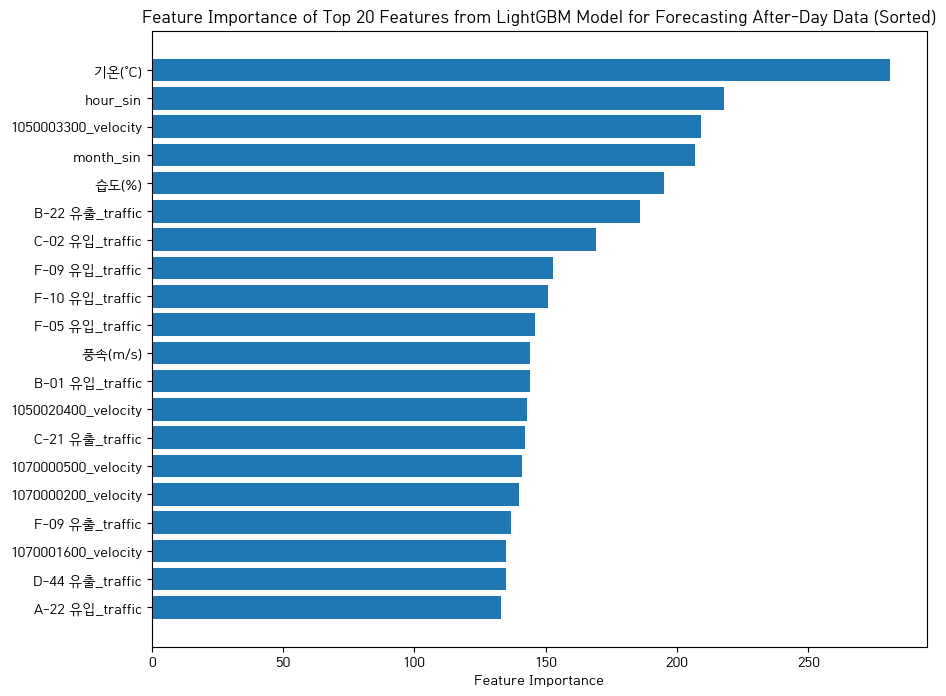

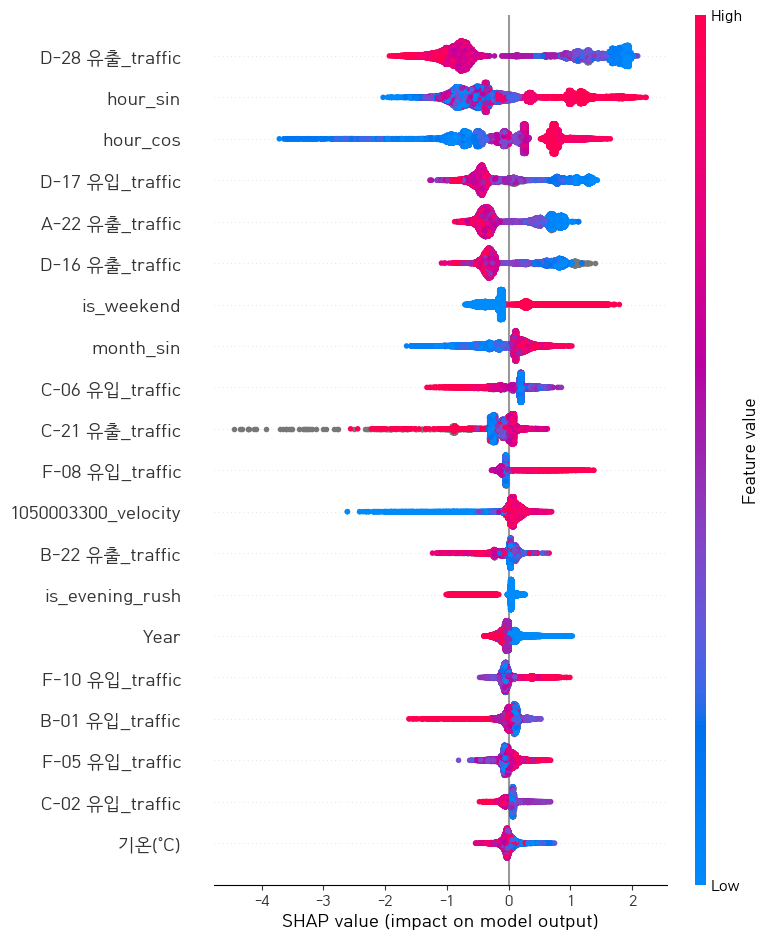

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import numpy as np

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/HANDotum.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False  
import shap

# 1. Feature Importance (LightGBM 제공)
# Feature importance 시각화
feature_importances = lgb_model.feature_importances_
feature_names = X_train.columns

# Feature Importance 정렬 (내림차순)
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx][:20]
sorted_feature_names = X_train.columns[sorted_idx][:20]

# 정렬된 중요도 막대그래프
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, align='center')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Top 20 Features from LightGBM Model for Forecasting After-Day Data (Sorted)")
plt.gca().invert_yaxis()  # y축을 내림차순으로 정렬
plt.show()

# 2. SHAP Analysis
# SHAP 값을 계산하고, 각 feature의 영향력을 시각화
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# Summary plot: 전체 feature의 SHAP 값 시각화
shap.summary_plot(shap_values, X_train)

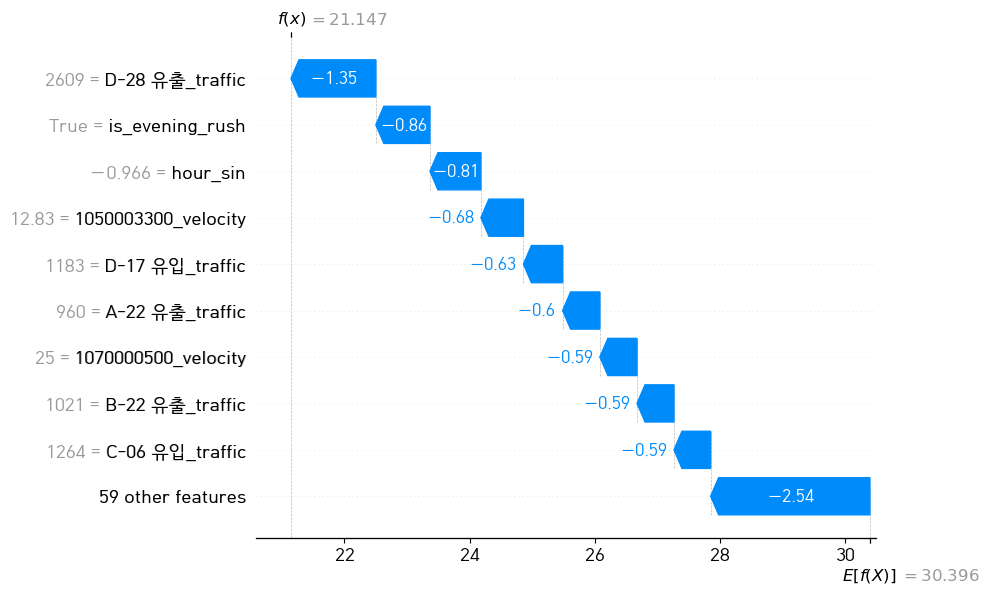

In [16]:
# 데이터 포인트의 SHAP waterfall plot 생성
shap.waterfall_plot(shap.Explanation(values=shap_values[19183], base_values=explainer.expected_value, data=X_train.iloc[19183]))

# 그래프 표시
plt.show()